<a href="https://colab.research.google.com/github/mreda1998/Radiomics/blob/main/Radiomics_and_treatment_outcome_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Radiomics and Treatment Outcome Prediction**

Thanks to the McMedHacks team especially Ibrahim Chamseddine, Ph.D.
Postdoctoral Fellow in Radiation Oncology, Massachusetts General Hospital, Harvard Medical School for the Help



# **Part I: Outcome Prediction**

### Is to estimate the (probability of) occurence of clinical endpoints after treatment

![picture](https://drive.google.com/uc?id=1N2RhTX3DU8WbvAGEcdPNScwPFEqbSNwE)

![picture](https://drive.google.com/uc?id=1hmXz7AFvtdoAPrgjPUXoQ7nV35CM7qox)

<br>
<br>

* **Tranditional methods** use dose estimates such as [DVH](https://en.wikipedia.org/wiki/Dose-volume_histogram)

![picture](https://drive.google.com/uc?id=1qtlL8arexu7Y6PYODDCNZSq4m3QtET4A)
* They ignore interpatient variabilities
* **Data science** considers patient characteristics
* It enables individualized prediction

---

### Why to perform outcome prediction:
* Patient stratification into risk groups
* Treatment selection/modification based on the predicted outcome
* Enrichment of clinical trails: selecting the patients cohort in which the effect of treatment can be more demonstrated. Recommended reading [Artificial Intelligence for Clinical Trial Design](https://www.sciencedirect.com/science/article/pii/S0165614719301300#f0010)

---

### Forms of outcome prediction:
* **Classification**, especially *binary*
* **Regression**, including probability of occurence
* **Survival analysis** or **time-to-event** models

---



## **Types of data**

#### Independent variables are treatment- or patient-specific features
* Clinical variables (e.g., tumor size, stage, patient's age)
* Treatment variables (e.g., dose, schedule, fractionation, dosimetric indices)
* Images (e.g., CTs , MRIs, dosemaps)


#### Dependent variables are outcome to be predicted
* Overall survival
* Local control
* *Sometimes nonlocal control is important!*
* Toxicity endpoints - varies by site (e.g., pneumonitis in lung cancer and RILD in liver cancer)
* *Lymphopenia is an emerging endpoint in the era of immunotherapy*



---
 ## **Feature significance**
* Prior to model development, it is a good practice to check which features discriminate the data
* This can be done using uni- and multi-variate analyses
* One measurment of feature significance is p-value
* Which helps in **feature selection**

* This is an example of quality of life variables from
[link](https://www.researchgate.net/publication/305487559_Sex_differences_in_the_quality_of_life_of_patients_with_acute_coronary_syndrome_treated_with_percutaneous_coronary_intervention_after_a_3-year_follow-up)

![picture](https://drive.google.com/uc?id=1_04XHt3sk_f9GXusp5ljUApvG3nbF6a_)



* *Some features with high p-value have confounding effect!*

### How to study the significance of deep features such as images?
#### **Voxel-based analysis (VBA)**
* VBA identified image subregions responsible to the outcome
* This example, taken from [Palma et al. 2019](https://www.redjournal.org/article/S0360-3016(19)30274-3/fulltext), shows the significance map in -log *p* of the differences in Biologically Effective Dose between patients w/o radiation-induced lung damage.
<br>
<br>

![picture](https://drive.google.com/uc?export=view&id=1wZhsPOfzQOzcr6fKkt7IoLqjWvt-KIkU)

# **Part II: Voxel-Based Analysis**

* Assume we divide the patients into 2 groups: positive and negative outcome

* Go to the dose map voxel-by-voxel and check if there is a difference between the dose distribution in each group

* If yes, then the voxel may be critical. But how to measure the difference in dose distribution? **statistical hypothesis testing**

* In each voxel assume that the null hypothesis $H_0:=$ positive and negative patients have the same mean dose in voxel $v_i$


\
![picture](https://drive.google.com/uc?export=view&id=1bN-inYtWJ9e1fpJfOQqTd67IIkPrSXeQ)

\

* We need to calculate p-value in each voxel

* p-value is calculated using a statistical test. See [how to choose the correct statistical test](https://stats.idre.ucla.edu/other/mult-pkg/whatstat/)

* If $p < \alpha$, $H_0$ can be rejected and the voxel is considered significant

\
![picture](https://drive.google.com/uc?export=file&id=1vg10pd1rgJfRqwAWYfz4nJLTJ6fF3CMG)



**Import data**

Data obtained from [Cancer Imaging Archive](https://www.cancerimagingarchive.net)

In [ ]:
# downloading the zip folder data directly from the google drive link
! pip install gdown
! gdown --id 1gSpT8Os6TqjP_ho8rZ0WndEEFW2zkE88

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1gSpT8Os6TqjP_ho8rZ0WndEEFW2zkE88
To: /content/data.zip
100% 2.65G/2.65G [00:19<00:00, 135MB/s]


In [ ]:
import os
import zipfile
import gdown

with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall("./")

In [ ]:
! pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 37 kB/s 


**Libraries**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import random
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import SimpleITK as sitk

**Extract clinical data and outcome**

In [ ]:
df_cln = pd.read_excel('data/Clinical_data_modified_2.xlsx', sheet_name = 'CHUM')
df_cln.head()

,Patient #,Sex,Age,Stage,Time – diagnosis to last follow-up(days),Locoregional,Distant,Death,Time – diagnosis to LR (days),Time – diagnosis to DM (days),Time – diagnosis to Death (days)
0,HN-CHUM-001,2,82.0,4,1806,0,0,1,NaN,NaN,NaN
1,HN-CHUM-002,2,73.0,4,805,1,0,0,571.0,NaN,NaN
2,HN-CHUM-003,2,56.0,4,1841,0,0,0,NaN,NaN,NaN
3,HN-CHUM-004,2,62.0,4,1776,0,0,1,NaN,NaN,NaN
4,HN-CHUM-005,1,67.0,4,1725,0,0,0,NaN,NaN,NaN


Text(0.5, 1.0, 'Death')

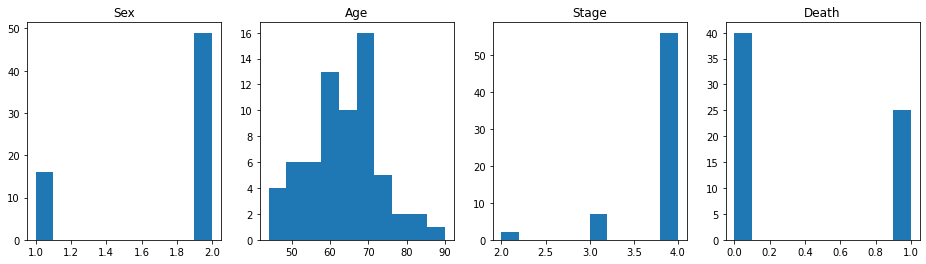

In [ ]:
# Let's take a look at the statistics of data
fig, axs = plt.subplots(1, 4, figsize=(16,4))
axs[0].hist(df_cln.Sex)
axs[1].hist(df_cln.Age)
axs[2].hist(df_cln.Stage)
axs[3].hist(df_cln.Death)

axs[0].set_title("Sex")
axs[1].set_title("Age")
axs[2].set_title("Stage")
axs[3].set_title("Death")


**Disclaimer: Do NOT use this data for biological or clinical interpretation or practice**

**Extract dosimetric information**

All images were registered to a reference image using [Plastimatch](https://plastimatch.org/)

In [ ]:
n_patients = 56
dim1 = 185 - 70
dim2 = 170 - 30
dim3 = 230 - 40


# Clinical data and outcomes
df_cln = pd.read_excel('data/Clinical_data_modified_2.xlsx', sheet_name = 'CHUM')
features = ['Sex', 'Age', 'Stage']
n_cln = len(features)

# Get patient's ID
p_id = list(range(1, n_patients+1))
p_id = [format(idx, '03d') for idx in p_id]

X_cts = np.zeros( (len(p_id), dim1, dim2, dim3) )      # CT scans - 3D
X_dos = np.zeros( (len(p_id), dim1, dim2, dim3) )      # dose maps - 3D
X_cln = np.zeros( (len(p_id), n_cln) )                 # clinical variables - 1D
X_gtv = np.zeros( (len(p_id), dim1, dim2, dim3) )      # GTV contours  - 3D

y     = np.zeros( (len(p_id) ) ) # outcomes - binary

# Read data
for ip, p in enumerate(p_id):

    if ip%5 == 0:
        print(f" Extracting data ... {ip:>3d}/{n_patients} patients")

    # CT scanes
    image = sitk.ReadImage(f'data/warpedCT/warped_{p}.mha')
    image = sitk.GetArrayFromImage(image)
    image = image[70:185, 30:170, 40:230]
    X_cts[ip, :, :, :] = image

    # Dose maps
    image = sitk.ReadImage(f'data/warpedDose/HN-CHUM-{p}-dose-refct.mha')
    image = sitk.GetArrayFromImage(image)
    image = image[70:185, 30:170, 40:230]
    X_dos[ip, :, :, :] = image

    # Clinical
    for ix, x in enumerate(features):
        X_cln[ip, ix] = df_cln[x][ip]

    # Outcomes
    y[ip] = df_cln['Death'][ip]


    # Also GTV contours for later use
    image = sitk.ReadImage(f'data/warpedGtv/HN-CHUM-{p}-gtv-refct.mha')
    image = sitk.GetArrayFromImage(image)
    image = image[70:185, 30:170, 40:230]
    X_gtv[ip, :, :, :] = image


print()

print(f"{sum(y)}/{len(y)} patients are positive")

 Extracting data ...   0/56 patients
 Extracting data ...   5/56 patients
 Extracting data ...  10/56 patients
 Extracting data ...  15/56 patients
 Extracting data ...  20/56 patients
 Extracting data ...  25/56 patients
 Extracting data ...  30/56 patients
 Extracting data ...  35/56 patients
 Extracting data ...  40/56 patients
 Extracting data ...  45/56 patients
 Extracting data ...  50/56 patients
 Extracting data ...  55/56 patients

24.0/56 patients are positive


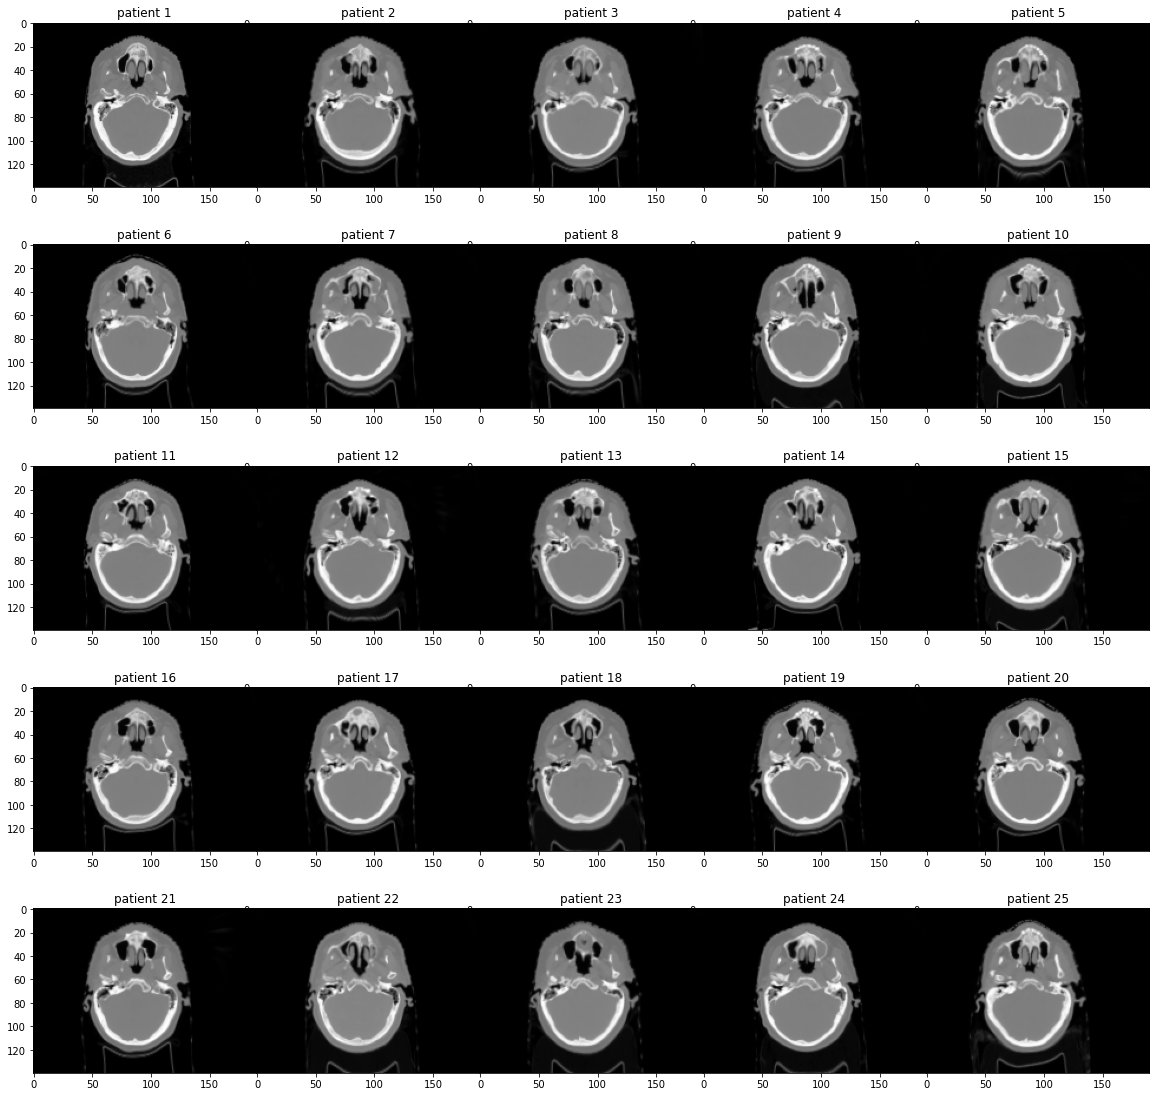

In [ ]:
# Let us diplay some slices
slc = 60
fig, axs = plt.subplots(5,5, figsize=(20, 20))
fig.subplots_adjust(hspace = .1, wspace=.001)
axs = axs.ravel()

for i in range(25):
    axs[i].imshow(X_cts[i, slc,:,:], cmap=plt.cm.Greys_r)
    axs[i].set_title(f"patient {i+1}")



**Reduce the size of the image to speed things up**

In [ ]:
from scipy import ndimage

RF = 0.3

print(f"number of voxels before resampling= {dim1*dim2*dim3}")

x_cts = ndimage.zoom(X_cts, (1, RF, RF, RF))
x_dos = ndimage.zoom(X_dos, (1, RF, RF, RF))

dim1, dim2, dim3 = np.shape(x_cts)[1], np.shape(x_cts)[2], np.shape(x_cts)[3]

print(f"number of voxels after resampling = {dim1*dim2*dim3}")


number of voxels before resampling= 3059000
number of voxels after resampling = 81396


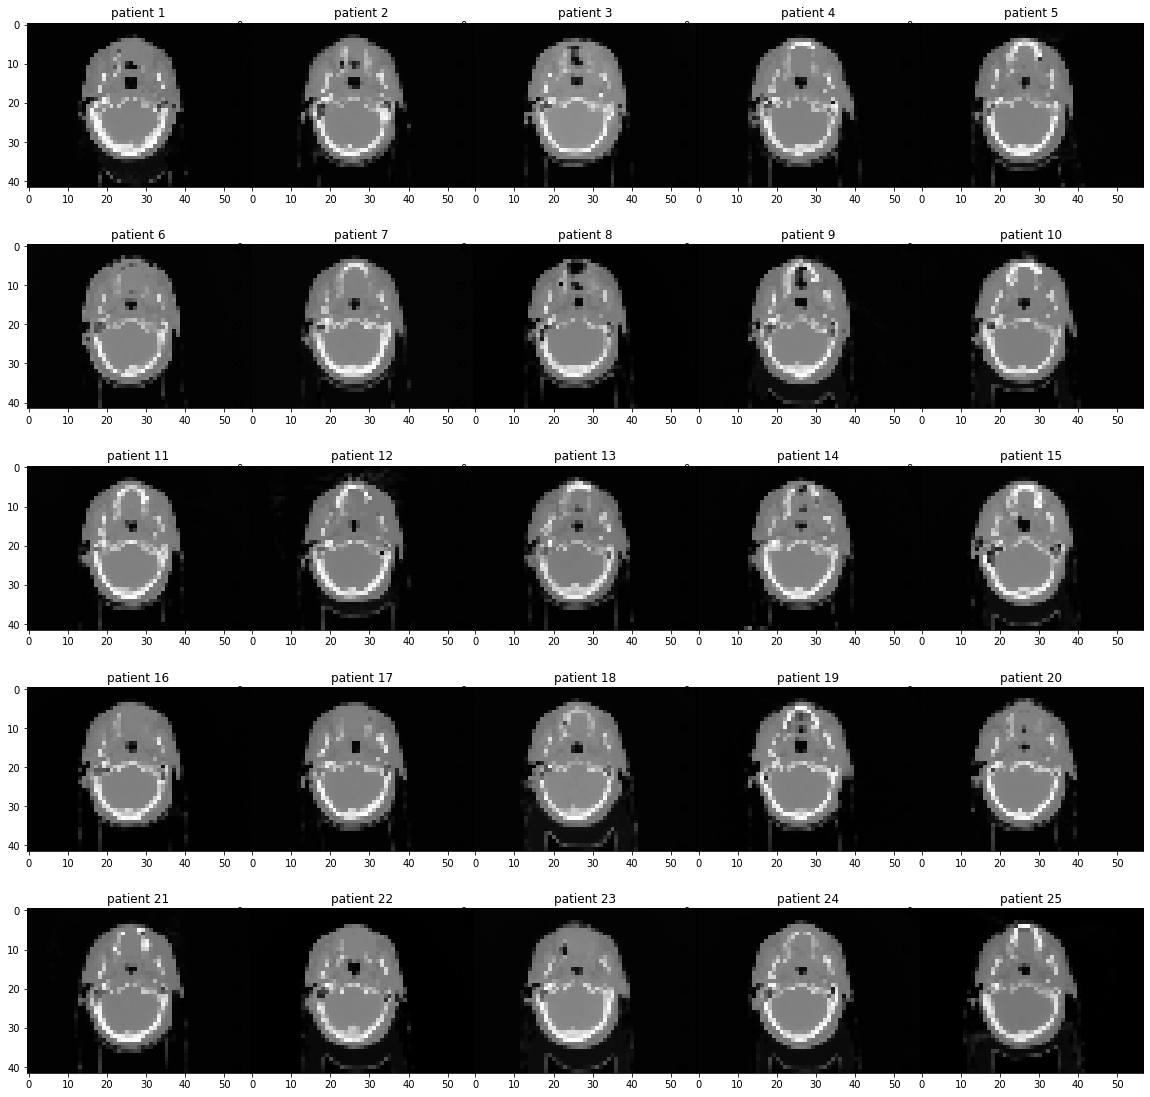

In [ ]:
fig, axs = plt.subplots(5,5, figsize=(20, 20))
fig.subplots_adjust(hspace = .1, wspace=.001)
axs = axs.ravel()
slc = 15

for i in range(25):
    axs[i].imshow(x_cts[i, slc,:,:], cmap=plt.cm.Greys_r)
    axs[i].set_title(f"patient {i+1}")

## 2. Statistical significance and p-value

In [ ]:
from scipy.stats import mannwhitneyu
U    = np.zeros((dim1, dim2, dim3))
pval = np.ones((dim1, dim2, dim3))

# For each voxel
for ii in range(dim1):
    for jj in range(dim2):
        for kk in range(dim3):

            # Combine voxel doses of neg/pos patients together
            group_0 = X_dos[:,ii,jj,kk] [y == 0]
            group_1 = X_dos[:,ii,jj,kk] [y == 1]

            if sum(group_1) == 0:
                continue
            # Run statistical test to determine if they are significantly different
            # This is a 2 sample test
            # We have not checked the data distrubtion
            # So we will use a non-parametric test: Mann–Whitney U test
            # Other tests include Student's t-test, Wilcoxon test, Karuskal-Wallis, etc
            # Each test has its own adjavntages and disadvantages

            U[ii,jj,kk], pval[ii,jj,kk]= mannwhitneyu(group_0, group_1)

    if ii%10 == 0:
        print(f"Slice {ii}")


Slice 0
Slice 10
Slice 20
Slice 30


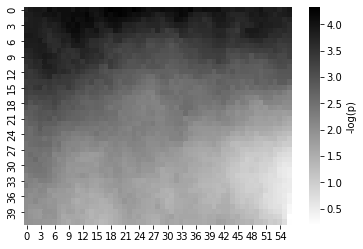

In [ ]:
import seaborn as sns
sl = 25
sns.heatmap(-np.log( pval[sl,:,:] ), cbar_kws = {'label': '-log(p)'}, cmap = 'gray_r')

Total number of hits : 41606/81396


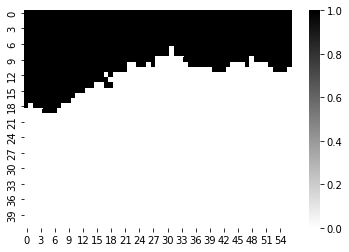

In [ ]:
#%% significance
alpha = 0.05 # significance level
hits = np.zeros((dim1, dim2, dim3))
hits[ pval < alpha ] = 1

sns.heatmap(hits[sl,:,:], cmap = 'gray_r')
print(f"Total number of hits : {hits.sum().astype(int)}/{dim1*dim2*dim3}")



## 3. Multiple Testing Correction

![picture](https://drive.google.com/uc?file=export&id=1HVeOGepqcrZ8v_HrRU3oCC4pz1nHGaho)

* $m$ is the total number of tests (number of voxels in our application)

* $m_0$ is the total number of cases the null hypothesis can be rejected (number of significant voxels), whether we detect it or not

* $m_1$ is the total number of cases the null hypothesis is true (number of insignificant voxels), whether we detect it or not

* $R$ is the number of cases we reject the null hypothesis, whether it is true or not

* $m-R$ is the number of cases we accept the null hypothesis, whether it is true or not

* $\frac{U}{m_0}$ is the true positive rate

* $\frac{S}{m_1}$ is the true negative rate

* $T$ is the number of false positives, also know as *Type I error*

* $T$ is the number of false nagatives, also know as *Type II error*

* **We aim to maximize the diagonal entries and minimize the off-diagonal ones**

* When multiple tests are done simultaneously, the probability of observing at least one significant results *just by chance* increases

$ P(\text{at least 1 significant result})  = 1 - P(\text{no significant result}) = 1 - (1-\alpha)^m$

* For $(\alpha=0.05, m=100)$, there is a 99.4% chance of false positive

* This is called **Multiple Comparisons Problem** leading to **Family-wise Error Rate (FWER)**

* Therefore, multiple tests are prone to type I error


**There are methods to correct for FWER**. The objective to adjust the significance level

* They are based on finding an adjusting significance level for rejecting $H_0$

* Bonferroni correction: $\alpha/m$

* Sidak correction: $1-(1-\alpha)^\frac{1}{m}$

* Benjamini-Hotchberg: see slide 20 [here](https://www.gs.washington.edu/academics/courses/akey/56008/lecture/lecture10.pdf)

* Permutation test watch this video on [Permutation tests that control for multiple comparisons](https://www.youtube.com/watch?v=zg0tmnGGwBI)

* Recommended reading [Statistical parametric maps in functional imaging: A general linear approach](https://onlinelibrary.wiley.com/doi/abs/10.1002/hbm.460020402)



Text(0.5, 1.0, 'After correction:      hits : 0')

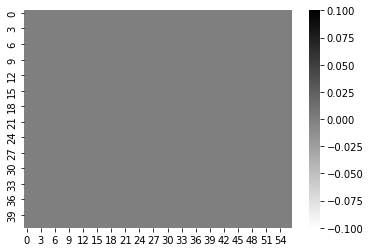

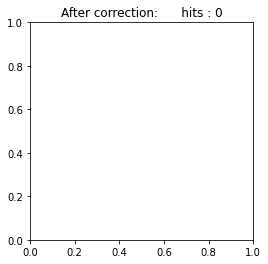

In [ ]:
# Bonferroni correction
m = (dim1*dim2*dim3)
alpha = 0.05
alpha = alpha/m
hits = np.zeros((dim1, dim2, dim3))
hits[ pval < alpha ] = 1

sns.heatmap(hits[sl,:,:], cmap = 'gray_r')
plt.figure(figsize=(4, 4))
plt.title("After Correction")
plt.title(f"After correction:      hits : {hits.sum().astype(int)}")


# **Part III: Outcome Modeling**

* We will us CNN to predict the outcome from CT scans, dose maps and patient-specific clinical variables

* The model is composed on 2 paths; one to extract features from the images and the other process clinical variables

* We will concatenate both paths before prediction

* Recommended reading: [Ibragimov et al., IEEE J Biomed Health Inform., 2019](https://aapm.onlinelibrary.wiley.com/doi/10.1002/mp.13122), where the image below was taken from

![picture](https://drive.google.com/uc?export=view&id=1w1iOzZ7PqoypgPtE7pQHNEk_665Om4lI)


* We will create something similar



In [ ]:
# Reduce the images further

RF = 0.2

x_cts = ndimage.zoom(X_cts, (1, RF, RF, RF))
x_dos = ndimage.zoom(X_dos, (1, RF, RF, RF))

dim1, dim2, dim3 = np.shape(x_cts)[1], np.shape(x_cts)[2], np.shape(x_cts)[3]

print(f"number of voxels after resampling = {dim1*dim2*dim3}")

number of voxels after resampling = 24472


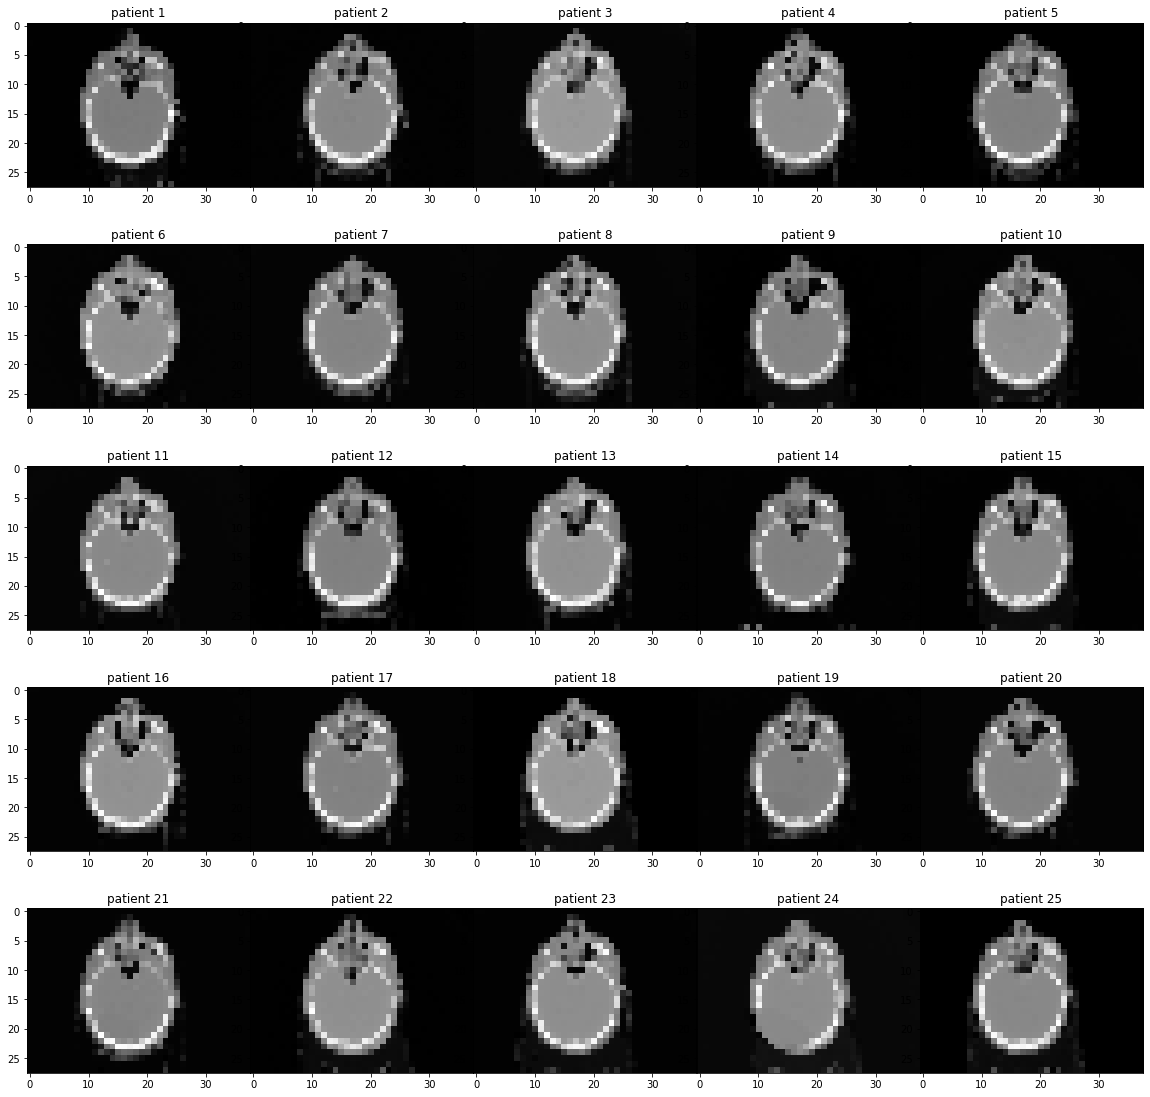

In [ ]:
# Let's check now how it looks like
fig, axs = plt.subplots(5,5, figsize=(20, 20))
fig.subplots_adjust(hspace = .1, wspace=.001)
axs = axs.ravel()
slc = 15

for i in range(25):
    axs[i].imshow(x_cts[i, slc,:,:], cmap=plt.cm.Greys_r)
    axs[i].set_title(f"patient {i+1}")

In [ ]:
# import some more libraries

# for creating the test and validation set
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# for evaluating the model
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_recall_curve
from scipy import interp

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import Adam, SGD
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Bootstrapping
from random import randrange

## 1. Construct the network

In [ ]:
class Net(nn.Module):

    # Network Architecture
    #
    # dosemap and CT scans --> conv --> normalization --> relu --> max pooling -->
    #       flattening -->
    # Adding clinical path
    #       FC reduce X to the size of X_clinical --> normalize --> rrelu -->
    #       X + X_clinic -->
    #       FC --> normalize --> rrelu -->
    #       FC --> normalize --> sigmoid




    def __init__(self):

        super(Net, self).__init__()

        ks    = 10
        pool  = 5

        # Convolution layers
        n_in  = 2
        n_out = 1
        self.conv1 = nn.Conv3d(in_channels = n_in, out_channels = n_out, kernel_size = ks)
        self.conv1_bn = nn.BatchNorm3d(n_out)


        # Pooling layers
        self.maxpool1 = nn.MaxPool3d(kernel_size = pool)

        # Flattening
        self.flat = nn.Flatten()

        # Fully-conneceted layers

        # FC 1: make the size of x equal to the of the clinical path


        I1, P, K, S = dim1, 0, ks, 1
        O1 = (I1 - K + 2*P) / S + 1
        O1 = (O1 - pool)/pool + 1
        O1 = int(O1)

        I2 = dim2
        O2 = (I2 - K + 2*P) / S + 1
        O2 = (O2 - pool)/pool + 1
        O2 = int(O2)

        I3 = dim3
        O3 = (I3 - K + 2*P) / S + 1
        O3 = (O3 - pool)/pool + 1
        O3 = int(O3)

        self.fc1 = nn.Linear(O1*O2*O3, n_cln)
        self.fc1_bn = nn.BatchNorm1d(n_cln)

        # FC 2: expand the features after concatination
        L_in = int ( 2 * n_cln )
        L_out = int ( L_in)
        self.fc2 = nn.Linear(L_in, L_out)
        self.fc2_bn = nn.BatchNorm1d(L_out)

        # FC 3: make prediction
        self.fc3 = nn.Linear(L_out, 1)
        self.fc3_bn = nn.BatchNorm1d(1)



    def forward(self, x_dos, x_cts, x_cln):


        # Concatenate dosimetric and clinical features
        x = torch.cat((x_dos, x_cts), dim=1)

        # average pooling
        x = self.maxpool1(  F.rrelu(  self.conv1_bn(  self.conv1(x)  )  )  )

        x = self.flat(x)

        # FC layer to reduce x to the size of the clinical path
        x = F.rrelu( self.fc1_bn( self.fc1(x) ) )


        # Concatinate clinical variables
        x_cln = x_cln.squeeze(1)
        x_final = torch.cat((x, x_cln), dim=1)

        # Last FCs
        x_final = F.rrelu  ( self.fc2_bn( self.fc2(x_final) ) )
        x_final = torch.sigmoid( self.fc3_bn( self.fc3(x_final) ) )

        return x_final.squeeze()


In [ ]:
#%% Construct the model
model1 = Net()
print(model1)

Net(
  (conv1): Conv3d(2, 1, kernel_size=(10, 10, 10), stride=(1, 1, 1))
  (conv1_bn): BatchNorm3d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool3d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=30, out_features=3, bias=True)
  (fc1_bn): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=6, out_features=6, bias=True)
  (fc2_bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=6, out_features=1, bias=True)
  (fc3_bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## 2. Data split and preprocessing

In [ ]:
#%% Split data
train = [int(x) for x in range(int(0.7*n_patients))]
test  = [x for x in range(n_patients-1) if x not in train]

X_dos_train, X_dos_test = x_dos[train,:,:,:], x_dos[test,:,:,:]
X_cts_train, X_cts_test = x_cts[train,:,:],   x_cts[test,:,:,:]
X_cln_train, X_cln_test = X_cln[train,:],     X_cln[test,:]
y_train, y_test         = y[train],           y[test]



# Normalize continuous clinical variables
var = 1 # index of 'Age'
mean = X_cln_train[:,var].mean()
std  = X_cln_train[:,var].std()
X_cln_train[:,var] = ( X_cln_train[:,var] - mean ) / std
X_cln_test [:,var] = ( X_cln_test [:,var] - mean ) / std


# convert data to tensors
X_cts_train  = torch.tensor(X_cts_train).float().unsqueeze(1)
X_dos_train  = torch.tensor(X_dos_train).float().unsqueeze(1)
X_cln_train  = torch.tensor(X_cln_train).float().unsqueeze(1)
# X_dvh_train  = torch.tensor(X_dvh_train).float().unsqueeze(1)
y_train      = torch.tensor(y_train).float()

X_cts_test  = torch.tensor(X_cts_test).float().unsqueeze(1)
X_dos_test  = torch.tensor(X_dos_test).float().unsqueeze(1)
X_cln_test  = torch.tensor(X_cln_test).float().unsqueeze(1)
# X_dvh_test  = torch.tensor(X_dvh_test).float().unsqueeze(1)
y_test      = torch.tensor(y_test).float()


# Combine datasets
bs = 10

train_set = TensorDataset(X_cts_train, X_dos_train, X_cln_train, y_train)
train_loader = DataLoader(train_set, batch_size = bs )

test_set = TensorDataset(X_cts_test, X_dos_test, X_cln_test, y_test)
test_loader = DataLoader(test_set, batch_size = bs )

## 3. Training

[ 20] 	 Train : 0.25413 	 Test : 0.24601
[ 40] 	 Train : 0.14307 	 Test : 0.13103
[ 60] 	 Train : 0.09627 	 Test : 0.08677
[ 80] 	 Train : 0.07031 	 Test : 0.06259


Text(0.5, 0, 'Epoch')

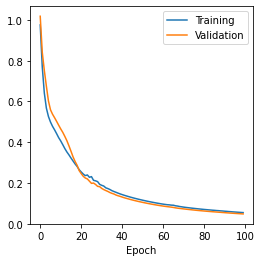

In [ ]:
n_epochs = 100
learning_rate = 0.01
optimizer = Adam(model1.parameters(), lr = learning_rate)
loss_fn = nn.BCELoss()



scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, \
                        factor=0.5, patience=5, min_lr=0.00001*learning_rate,\
                            verbose=False)


train_losses = []
test_losses = []
plt.figure(figsize = (4,4))
for epoch in range(n_epochs):
    train_loss = 0

    # Training
    model1.train()
    for batch, (X_cts_train, X_dos_train, X_cln_train, y_train) in enumerate(train_loader):
        # print(y_train)
        # loss function
        loss_fn = nn.BCELoss()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        pred_train = model1(X_cts_train, X_dos_train, X_cln_train)

        Tloss = loss_fn(pred_train, y_train)
        Tloss.backward()
        optimizer.step()

        train_loss += Tloss.item()

    train_loss = train_loss/(batch+1)
    scheduler.step(train_loss)
    train_losses.append(train_loss)

    # Model validation
    model1.eval()
    Y = torch.Tensor([])
    Y_hat = torch.Tensor([])
    batch_accuracy = 0
    test_loss = 0
    for batch, (X_cts_test, X_dos_test, X_cln_test, y_test) in enumerate(test_loader):
        pred_test  = model1(X_cts_test, X_dos_test, X_cln_test)
        Vloss = loss_fn(pred_train, y_train)
        test_loss += Vloss.item()

    test_loss = test_loss/(batch+1)
    test_losses.append(test_loss)


    # Plot results
    if epoch%20 == 0 and epoch != 0:
      print(f"[{epoch:>3d}] \t Train : {train_loss:0.5f} \t Test : {test_loss:0.5f}")


plt.plot(list(range(epoch+1)), train_losses, label = 'Training')
plt.plot(list(range(epoch+1)), test_losses,  label = 'Validation')
plt.legend()
plt.xlabel("Epoch")



## 4. Validation


**TRIPOD**

[Collins et al., *Br J Surg*, 2015](https://academic.oup.com/bjs/article/102/3/148/6136428?login=true) developed a checklist for
transparent reporting of a multivariable prediction model for individual prognosis or diagnosis - **TRIPOD statement**


*Below is Figure 3 of the paper*

![picture](https://drive.google.com/uc?edxport=view&id=1d2vDqPx0MHWpYxZo46vqSueJGT38JyH_)

**ROC**

* Receiver operating characteristics (ROC) curve measures the tradeoff between False Positive Rate (FPR) and True Negative Rate (TPR)

* It is used to assess the model ability to discriminate samples according to a **moving threshold**

* The upper left corner represents perfect prediction (TPR = 1 and FPR = 0)

* The area under the curve **AUC** is used to measure the model performance

* Perfect prediction AUC = 1

* Random prediction AUC = 0.5



AUC : 0.4285714285714286


Text(0.5, 0, 'False Positive Rate')

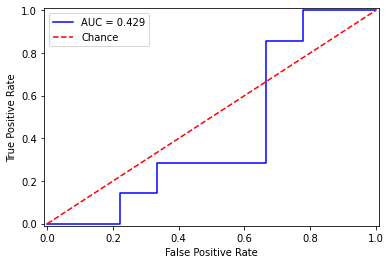

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# Make prediction using the testing dataset
model1.eval()
y_true = torch.Tensor([])
y_pred = torch.Tensor([])
batch_accuracy = 0
for batch, (x_test, x_ct_test, x_clinical_test, y_test) in enumerate(test_loader):
    pred   = model1(x_test, x_ct_test, x_clinical_test)
    y_true = torch.cat((y_true,y_test))
    y_pred = torch.cat((y_pred,pred))


# Calculate AUC
auc = roc_auc_score(y_true.detach().numpy().astype(int), y_pred.detach().numpy())
print(f"AUC : {auc}")

# Plot ROC Curve
fpr, tpr, thr = roc_curve(y_true.detach().numpy(), y_pred.detach().numpy())
plt.plot(fpr, tpr, 'b', label = f"AUC = {auc:0.3f}")
plt.plot([0, 1], [0, 1],'r--', label = 'Chance')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


**Confusion-Matrix**

* In some cases, AUC is high but only because of high TPR or TNR but not both

* This can happen in data imbalance and is critical when the minority group is imporant

* Confusion matrix is a table of the form

![picture](https://drive.google.com/uc?export=view&id=1UdKCpVpyNLi43oSfP5CEP9JshFz5UIYV)

* However, you need to specify the decision threshold


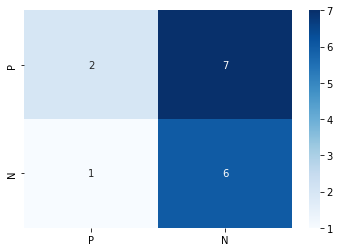

In [ ]:
from sklearn.metrics import confusion_matrix

def to_labels(pos_probs, threshold):
        return (pos_probs >= threshold).astype('int')

thr = .2
CM = confusion_matrix(y_true.detach().numpy().astype(int), to_labels(y_pred.detach().numpy(), thr).astype(int))

df_cm = pd.DataFrame(CM, index = [i for i in "PN"],
                  columns = [i for i in "PN"])
sns.heatmap(df_cm, annot=True, cmap = 'Blues')


**Precision-Recall Curve**

* The ROC curve may be optimistic when there is a data imbalance

* In such a case, the precision-recall curve should be considered

* Perfect performance is the upper right corner of the curve

* Recommended reading: [The relationship between Precision-Recall and ROC curves](https://dl.acm.org/doi/10.1145/1143844.1143874)

Text(0, 0.5, 'Precision')

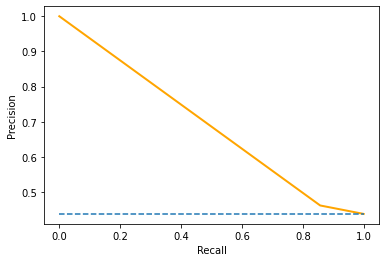

In [ ]:
from sklearn.metrics import precision_recall_curve

prec, recall, thr2 = precision_recall_curve(y_true.detach().numpy().astype(int), to_labels(y_pred.detach().numpy(), thr).astype(int))

plt.plot(recall, prec, 'orange', lw=2)
no_skill = len(y_true[y_true==1]) / len(y_true)
plt.plot([0, 1], [no_skill, no_skill], '--')
plt.xlabel('Recall')
plt.ylabel('Precision')

# **Part IV: Prediction using DVH**

* The dose-volume histogram (DVH) is a 2-D representation of the 3D dose maps

* It is used to evaluate plans and assess toxicity in organs-at-risk

![picture](https://drive.google.com/uc?export=view&id=1i5K-C0j6DD91VaoNGb4tLD3ZQT5YTLWs)

Plot taken from https://link.springer.com/chapter/10.1007/978-3-030-61899-5_12




* In certain cases, the DVH could be adequate for prediction

* Although it ignores spatial information, the use of DVH saves significant computational cost, which could allow for better tuning and cross-validation of the model

* The DVH can be processed by the CNN as a signal/1D array

[Cui et al. *Int J Rad Onc Bio Phys*, 2020](https://pubmed.ncbi.nlm.nih.gov/33539966/)

![picture](https://drive.google.com/uc?export=view&id=1ZfwuQztYHxFaDlmT_gRmPWmg67lDXpqJ)


### Extract DVH from dose maps

* Typically, the GTV dose is removed since DVH is calculated for different organs-at-risk (OAR)

* OARs are site-dependent

* Here, we are treating the entire head as OAR for demonstration purposes only

* In practice, specific OARs are tied to clinical endpoints, for which countours should be used



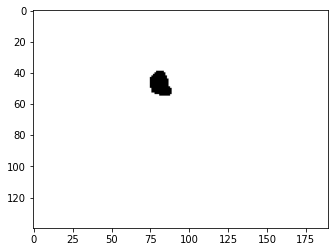

In [ ]:
# This can be done by appying GTV masks obtained by contours
plt.imshow(X_gtv[0,30,:,:], cmap='gray_r')

In [ ]:
dGy = 1
bin_edges = [i*dGy for i in range(76)]
X_dvh = np.zeros( (len(p_id), len(bin_edges)-1) )   # DVH - 1D

for ip, p in enumerate(p_id):

    if ip%5 == 0:
        print(f" Extracting DVH ... {ip:>3d}/{n_patients} patients")

    # Remove GTV
    dosemap  = X_dos[ip,:,:,:].copy()
    dosemap -= dosemap*X_gtv[ip,:,:,:]

    # Calculate DVH
    dvh, bins = np.histogram(dosemap, bins=bin_edges)

    # Noramlize the area under the diff DVH to 1
    dvh = dvh / sum(dvh*np.diff(bin_edges))


    X_dvh[ip, :] = dvh


 Extracting DVH ...   0/56 patients
 Extracting DVH ...   5/56 patients
 Extracting DVH ...  10/56 patients
 Extracting DVH ...  15/56 patients
 Extracting DVH ...  20/56 patients
 Extracting DVH ...  25/56 patients
 Extracting DVH ...  30/56 patients
 Extracting DVH ...  35/56 patients
 Extracting DVH ...  40/56 patients
 Extracting DVH ...  45/56 patients
 Extracting DVH ...  50/56 patients
 Extracting DVH ...  55/56 patients


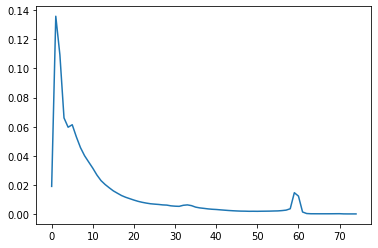

In [ ]:
# But let's take a look at how the DVH looks like
plt.plot(bins[0:-1],X_dvh[4, :])

* Note that often times, there is a spike at zero dose that is dominating the signal

* This is a result of organ sparing and could be more evident in conformal RT and proton therapy

* Removing the spike can increase mean dose and total dose

* This can be corrected by passing the dosimetric indices or mean dose or EUD in the clinical path



In [ ]:
# Define the network
class Net(nn.Module):
    # Hyperparameters:
    #   kernel size of the concolution layer     (1)
    #   size of the average pooling              (1)

    def __init__(self, ks, pool):
        super(Net, self).__init__()


        # Convolution layers
        n_in  = 1
        n_out = 1
        self.conv1 = nn.Conv1d(in_channels = n_in, out_channels = n_out, kernel_size = ks)
        self.conv1_bn = nn.BatchNorm1d(n_out)


        # Pooling layers
        self.avgpool1 = nn.AvgPool1d(kernel_size = pool)

        # Flattening
        self.flat = nn.Flatten()


        # Fully-conneceted layers

        # --- FC 1: make the size of x equal to the of the clinical path
        n_cln = X_cln.shape[-1]

        I, P, K, S = X_dvh.shape[1], 0, ks, 1
        O = (I - K + 2*P) / S + 1
        O = (O - pool)/pool + 1

        O = int(O)

        self.fc1 = nn.Linear(O, n_cln)
        self.fc1_bn = nn.BatchNorm1d(n_cln)

        # --- FC 2: Allow features to interact
        L_in = int ( 2 * n_cln ) # since the dvh and clinical paths are now equal --> 2 X
        L_out = int ( L_in )
        self.fc2 = nn.Linear(L_in, L_out)
        self.fc2_bn = nn.BatchNorm1d(L_out)

        # --- FC 3: make prediction
        self.fc3 = nn.Linear(L_out, 1)
        self.fc3_bn = nn.BatchNorm1d(1)


    def forward(self, X_dvh, X_cln):

        # average pooling
        x = self.avgpool1(  F.rrelu(  self.conv1_bn(  self.conv1(X_dvh)  )  )  )

        x = self.flat(x)


        # FC layer to reduce x to the size of the clinical path
        x = F.relu ( self.fc1_bn( self.fc1(x) ) )


        # Concatinate clinical variables
        X_cln = X_cln.squeeze(1)
        x_fin = torch.cat((x, X_cln), dim=1)

        # Last FCs
        x_fin = F.rrelu  ( self.fc2_bn( self.fc2(x_fin) ) )
        x_fin = torch.sigmoid( self.fc3_bn( self.fc3(x_fin) ) )

        return x_fin.squeeze()


# Construct the model
kernel_size  = 5
pool_size   = 3
model2 = Net(kernel_size, pool_size)
print(model2)


Net(
  (conv1): Conv1d(1, 1, kernel_size=(5,), stride=(1,))
  (conv1_bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool1): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=23, out_features=3, bias=True)
  (fc1_bn): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=6, out_features=6, bias=True)
  (fc2_bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=6, out_features=1, bias=True)
  (fc3_bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


### Cross-validation

It train and test the model on different subsets of the data to reduce bias

![picture](https://drive.google.com/uc?export=view&id=1NkZklxSxilULySzldv0mAQ5V5lTQOUhk)

alternatively, one can use [**bootstrapping**](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) to resample the data


**First put the training step in a module to be called in each cross-validation fold**

In [ ]:

def train(n_epochs, train_loader, model2, loss_fn, optimizer):

    model2.train()

    for epoch in range(n_epochs):
        train_loss = 0

        # Training

        for batch, (X_dvh_train, X_cln_train, y_train) in enumerate(train_loader):

            # Loss function
            loss_fn = nn.BCELoss()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            pred_train = model2(X_dvh_train, X_cln_train)
            Tloss = loss_fn(pred_train, y_train)
            Tloss.backward()
            optimizer.step()

            train_loss += Tloss.item()

        train_loss = train_loss/(batch+1)


![picture](https://drive.google.com/uc?file=export&id=1t05IjzX-1A6mmgoDv3RaA53V6DHLeXAW)


**Second: cross-validate the model**

In [ ]:


from sklearn.model_selection import StratifiedKFold
bs = 14

# Cross-validation parameters
n_cv = 4
cv = StratifiedKFold(n_splits=n_cv)

# Training parameters
optimizer = Adam(model2.parameters(), lr = learning_rate)
loss_fn = nn.BCELoss()  # Check Train modeule. The loss function may be customized
n_epochs = 100



# Initialize metrics
aucs, tprs, fprs            = [], [], np.linspace(0, 1, 100)
f1s, precs, recalls         = [], [], np.linspace(0, 1, 100)


# Start CV
for k, (train_id, test_id) in enumerate(cv.split(X_dvh, y)):

    print('------------------------------------------')
    print(f"CV \t {k}")


    # PREPARE DATASETS
    X_dvh_train, X_dvh_test = X_dvh[train_id,:], X_dvh[test_id,:]
    X_cln_train, X_cln_test = X_cln[train_id,:], X_cln[test_id,:]
    y_train, y_test         = y[train_id],       y[test_id]

    # --- Normalize continuous clinical variables
    var = 1 # index of 'Age'
    mean = X_cln_train[:,var].mean()
    std  = X_cln_train[:,var].std()
    X_cln_train[:,var] = ( X_cln_train[:,var] - mean ) / std
    X_cln_test [:,var] = ( X_cln_test [:,var] - mean ) / std

    # --- Convert data to tensors
    X_dvh_train  = torch.tensor(X_dvh_train).float().unsqueeze(1)
    X_cln_train  = torch.tensor(X_cln_train).float().unsqueeze(1)
    y_train      = torch.tensor(y_train).float()

    X_dvh_test  = torch.tensor(X_dvh_test).float().unsqueeze(1)
    X_cln_test  = torch.tensor(X_cln_test).float().unsqueeze(1)
    y_test      = torch.tensor(y_test).float()


    # --- Combine datasets
    train_set = TensorDataset(X_dvh_train, X_cln_train, y_train)
    train_loader = DataLoader(train_set, batch_size = bs )

    test_set = TensorDataset(X_dvh_test, X_cln_test, y_test)
    test_loader = DataLoader(test_set, batch_size = bs )





    # Train the model of train data k
    train(n_epochs, train_loader, model2, loss_fn, optimizer)



    # Validate the model of val data k
    model2.eval()
    y_true = torch.Tensor([])
    y_pred = torch.Tensor([])
    batch_accuracy = 0
    for batch, (X_dvh_test, X_cln_test, y_test) in enumerate(test_loader):
        pred  = model2(X_dvh_test, X_cln_test)
        y_true = torch.cat((y_true,y_test))
        y_pred = torch.cat((y_pred,pred))


    # ROC
    auc_k = roc_auc_score(y_true.detach().numpy().astype(int), y_pred.detach().numpy())
    aucs.append(auc_k)
    fpr, tpr, _ = roc_curve(y_true.detach().numpy(), y_pred.detach().numpy())
    tpr = np.interp(fprs, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

    # TP, FP, TN, FN
    CM = confusion_matrix(y_true.detach().numpy().astype(int), np.round(y_pred.detach().numpy()).astype(int))
    TN = CM[0][0]
    FN = CM[1][0]
    FP = CM[0][1]
    TP = CM[1][1]
    print(f"\t TN   : {TN:>3d} \t \t FN  : {FN:>3d}")
    print(f"\t FP   : {FP:>3d} \t \t TP  : {TP:>3d} ")
    print(f"\t AUC  : {auc_k:0.3f}")



------------------------------------------
CV 	 0
	 TN   :   0 	 	 FN  :   0
	 FP   :   8 	 	 TP  :   6 
	 AUC  : 0.500
------------------------------------------
CV 	 1
	 TN   :   0 	 	 FN  :   0
	 FP   :   8 	 	 TP  :   6 
	 AUC  : 0.500
------------------------------------------
CV 	 2
	 TN   :   8 	 	 FN  :   5
	 FP   :   0 	 	 TP  :   1 
	 AUC  : 0.438
------------------------------------------
CV 	 3
	 TN   :   7 	 	 FN  :   0
	 FP   :   1 	 	 TP  :   6 
	 AUC  : 0.969


**Plot the ROC curve showing the confidence interval**

Text(0.5, 1.0, 'AUC 0.60 [0.44, 0.93]')

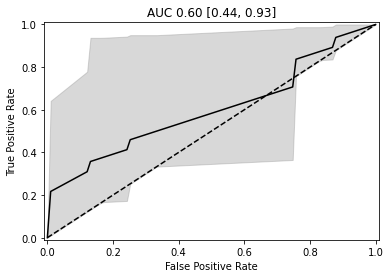

In [ ]:
# Plot Roc Curve
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
tprs_up = np.percentile(tprs, 97.5, axis = 0)
tprs_lo = np.percentile(tprs, 2.5, axis = 0)
auc_up = np.percentile(aucs, 97.5, axis = 0)
auc_lo = np.percentile(aucs, 2.5, axis = 0)
plt.fill_between(fprs, tprs_lo, tprs_up, color='grey', alpha=0.3)
plt.plot(fprs, mean_tprs, 'k')

plt.plot([0, 1], [0, 1],'k--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.title(f"AUC {np.mean(aucs):0.2f} [{auc_lo:0.2f}, {auc_up:0.2f}]")



* The jump at the lower left corner indicates a increase in TPR with small compromise of the FPR

* The plateau at the upper right corner indicates a decrease in FPR with small compromise of the TPR

* But the CI are not very narrow

## Network Optimization

* The network structure is defined by the hyperparameters: `number of convolution layers, number of pooling layers, number of fully connected layers, dropout rate, activation fucntion, etc `

* Hyperparameter optimization (HPO) or tuning may improve the perfomance of the network

* **Grid Search** and **Random Search** are widely used HPO algorithms

* Better methods such as **Model-based** and **Direct-Search** are useful when the search space is large

* Recommended reading: [Hyperparameter optimization of deep neural networks using mesh adaptive direct
search](https://arxiv.org/pdf/1907.01698.pdf)

* We will adapt our code to perform HPO using grid search.
* We will tune 3 hyperparameters: `kernel size of the convolution layer, kernel size of the pooling layer, learning rate of the optimizer`

In [ ]:
# ADAPT THE "train" CELL AND CONVERT IT TO A MODULE
# THAT TAKES HYPERPARAMETER VALUES AND RETURNS THE SCORE

#   def hp_score(kernel_size, pool_size, learning_rate):
#   model3 = Net(kernel_size, pool_size)
#   ...
#   return np.mean( np.array(aucs) )

# INDENT THE REST OF THE CODE
# TURN OFF THE PRINT FUNTIONALITY


![picture](https://drive.google.com/uc?file=export&id=1avTKrOYuZvJzXuLNxOo6PShJEf1pipXM)

In [ ]:
def hp_score(kernel_size, pool_size, learning_rate):

  model3 = Net(kernel_size, pool_size)

  # Cross-validation parameters
  n_cv = 4
  cv = StratifiedKFold(n_splits=n_cv)

  # Training parameters
  optimizer = Adam(model3.parameters(), lr = learning_rate)
  loss_fn = nn.BCELoss()
  n_epochs = 100



  # Initialize metrics
  aucs, tprs, fprs            = [], [], np.linspace(0, 1, 100)
  f1s, precs, recalls         = [], [], np.linspace(0, 1, 100)


  # Start CV
  for k, (train_id, test_id) in enumerate(cv.split(X_dvh, y)):

      # print('------------------------------------------')
      # print(f"CV \t {k}")


      # PREPARE DATASETS
      X_dvh_train, X_dvh_test = X_dvh[train_id,:], X_dvh[test_id,:]
      X_cln_train, X_cln_test = X_cln[train_id,:], X_cln[test_id,:]
      y_train, y_test         = y[train_id],       y[test_id]

      # --- Normalize continuous clinical variables
      var = 1 # index of 'Age'
      mean = X_cln_train[:,var].mean()
      std  = X_cln_train[:,var].std()
      X_cln_train[:,var] = ( X_cln_train[:,var] - mean ) / std
      X_cln_test [:,var] = ( X_cln_test [:,var] - mean ) / std

      # --- Convert data to tensors
      X_dvh_train  = torch.tensor(X_dvh_train).float().unsqueeze(1)
      X_cln_train  = torch.tensor(X_cln_train).float().unsqueeze(1)
      y_train      = torch.tensor(y_train).float()

      X_dvh_test  = torch.tensor(X_dvh_test).float().unsqueeze(1)
      X_cln_test  = torch.tensor(X_cln_test).float().unsqueeze(1)
      y_test      = torch.tensor(y_test).float()


      # --- Combine datasets
      train_set = TensorDataset(X_dvh_train, X_cln_train, y_train)
      train_loader = DataLoader(train_set, batch_size = bs )

      test_set = TensorDataset(X_dvh_test, X_cln_test, y_test)
      test_loader = DataLoader(test_set, batch_size = bs )


      # Train the model of train data k
      train(n_epochs, train_loader, model3, loss_fn, optimizer)



      # Validate the model of val data k
      model3.eval()
      y_true = torch.Tensor([])
      y_pred = torch.Tensor([])
      batch_accuracy = 0
      for batch, (X_dvh_test, X_cln_test, y_test) in enumerate(test_loader):
          pred  = model3(X_dvh_test, X_cln_test)
          y_true = torch.cat((y_true,y_test))
          y_pred = torch.cat((y_pred,pred))


      # ROC
      auc_k = roc_auc_score(y_true.detach().numpy().astype(int), y_pred.detach().numpy())
      aucs.append(auc_k)
      fpr, tpr, _ = roc_curve(y_true.detach().numpy(), y_pred.detach().numpy())
      tpr = np.interp(fprs, fpr, tpr)
      tpr[0] = 0.0
      tprs.append(tpr)

      # TP, FP, TN, FN
      CM = confusion_matrix(y_true.detach().numpy().astype(int), np.round(y_pred.detach().numpy()).astype(int))
      TN = CM[0][0]
      FN = CM[1][0]
      FP = CM[0][1]
      TP = CM[1][1]
      # print(f"\t TN   : {TN:>3d} \t \t FN  : {FN:>3d}")
      # print(f"\t FP   : {FP:>3d} \t \t TP  : {TP:>3d} ")
      # print(f"\t AUC  : {auc:0.3f}")


  return np.mean( np.array(aucs) )


**Perform HPO**

In [ ]:
! pip install smt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 252 kB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51 kB 748 kB/s 
     |████████████████████████████████| 3.2 MB 65.6 MB/s 
     |████████████████████████████████| 121 kB 72.4 MB/s 
     |████████████████████████████████| 100 kB 12.9 MB/s 
     |████████████████████████████████| 84 kB 4.1 MB/s 
     |████████████████████████████████| 90 kB 9.6 MB/s 
  Created wheel for smt: filename=smt-1.2.0-cp37-cp37m-linux_x86_64.whl size=527843 sha256=548153e9041bbda80b9a5a6b0d81c68c18a69bc8df36ab01f6f95263ee0fd883
  Stored in directory: /root/.cache/pip/wheels/3d/69/1e/ae0014b43757c2db9bdd61fdae3a4f532f9d64c451a1bc678e
  Created wheel for pyDOE2: filename=pyDOE2-1.3.0-py3-none-any.whl size=25539 sha256=e4a881f365b63a702a3cac3cacc9

In [ ]:
from smt.sampling_methods import FullFactorial
# Other sampling methods include Random; and Latin Hyper Cube

# Define the upper and lower bounds of the hyperparams
kernel_lims = [1., 10.]
pool_lims   = [1., 10.]
lr_lims     = [-4., 0] # 1e-4 - 0

limits = np.array([kernel_lims, pool_lims, lr_lims])

sampling = FullFactorial(xlimits=limits)

num = 10
samples = sampling(num)


best_AUC, best_KS, best_PS, best_LR = 0, 0, 0, 0

for iteration, sample in enumerate(samples):

  KS = int(sample[0])
  PS = int(sample[1])
  LR = 10**(sample[2])

  print("-------------------------------------------------------\n")
  print(f"HP Eval \t [{(iteration+1):>5d}/{num:>5d}]\n")
  print("Hyperparameters")
  print(f"\t Kernel Size     : {KS}")
  print(f"\t Pool Size       : {PS}")
  print(f"\t Learning Rate   : {LR:0.4f}")


  # Evaluate the HP
  AUC = hp_score(KS, PS, LR)
  print(f"\n AUC                    : {AUC:0.5f}")


  # Update best HPO
  if best_AUC<AUC:
      best_AUC = AUC
      best_KS = KS
      best_PS = PS
      best_LR = LR


print("-------------------------------------------------------\n")
print("End of HPO\n")
print(f"Best Hyperparameters")
print(f"\t Kernel Size     : {best_KS}")
print(f"\t Pool Size       : {best_PS}")
print(f"\t Learning Rate   : {best_LR}")
print(f"Best AUC  : {best_AUC:0.5f}\n")


-------------------------------------------------------

HP Eval 	 [    1/   10]

Hyperparameters
	 Kernel Size     : 1
	 Pool Size       : 1
	 Learning Rate   : 0.0001

 AUC                    : 0.66146
-------------------------------------------------------

HP Eval 	 [    2/   10]

Hyperparameters
	 Kernel Size     : 1
	 Pool Size       : 1
	 Learning Rate   : 1.0000

 AUC                    : 0.57812
-------------------------------------------------------

HP Eval 	 [    3/   10]

Hyperparameters
	 Kernel Size     : 1
	 Pool Size       : 10
	 Learning Rate   : 0.0001

 AUC                    : 0.60417
-------------------------------------------------------

HP Eval 	 [    4/   10]

Hyperparameters
	 Kernel Size     : 1
	 Pool Size       : 10
	 Learning Rate   : 1.0000

 AUC                    : 0.51562
-------------------------------------------------------

HP Eval 	 [    5/   10]

Hyperparameters
	 Kernel Size     : 5
	 Pool Size       : 1
	 Learning Rate   : 0.0001

 AUC        

# Part V: Refinements and Considerations

## Data Imbalance
* Always look at the precision-recall curve

* Under- or over-sampling may help but are my least favorite (personally) because they could result in data leak

* Better is to design a custom loss function

* Binary Cross Entropy: $loss ~ \sum y_ilog(p(y_i)) + (1-y_i)log(p(1-y_i))$

* You can add weights to emphasize the minority group


##Model Instability
* Model is very sensitive to train-test split

* Results in large variability among cross-validation/bootstrapping scores

* The model cannot be trusted unless it stabilizes

![picture](https://drive.google.com/uc?file=export&id=1zqZNIIx8AOxINIQrZ_7btvrGoZyLvmwT)

**How to treat model instability?**
* Increase sample size
* Use stronger regularization
* Reduce the number of hyperparameters
* [Model aggregation](https://pubmed.ncbi.nlm.nih.gov/18228011/)

## Preregistration of Study Analysis Plans
* Widely recognized in clinical trails

* Similarly, [Thor et al. 2020](https://pubmed.ncbi.nlm.nih.gov/32670879/) recommended preregistration of computational models prior to analysis to incease transperance

* SAPs should include enough details on the model and methods

* SAPs can be deposited in repositories such as the [Open Science Foundation](https://osf.io/?utm_term=&utm_campaign=OSF+General&utm_source=adwords&utm_medium=ppc&hsa_acc=5222345373&hsa_cam=217339509&hsa_grp=60774351098&hsa_ad=295172720879&hsa_src=g&hsa_tgt=dsa-520694377169&hsa_kw=&hsa_mt=b&hsa_net=adwords&hsa_ver=3&gclid=CjwKCAjwruSHBhAtEiwA_qCppscE488J0r2icrrV-M8VoQIjm9Ocy6UnAzRErk_a_SUI1seGWMmQyRoC_6oQAvD_BwE)

* Example: [Predicting radiotherapy outcomes in hepatocellular carcinoma](https://osf.io/7g6an)

## Comments on Multimodality

Different forms of images provide different information, which may compelemt each others to enhance the discriminative power of the predictive model.

![picture](https://drive.google.com/uc?file=export&id=1nUVVk2hr0PmB_oRl3zvDqjXYvmPiSder)

source [A review: Deep learning for medical image segmentation using multi-modality fusion](https://www.sciencedirect.com/science/article/pii/S2590005619300049#fig3)

* CT scans are faster, less expensive, and more widely used than MRI

* But MRI could provide more details to certain structures

* Selection is based on the application

* MRI is recommended if details of soft tissue, ligaments, or organs are needed

* It is frequently used top diagnose issues with the joints, brain, wrists, ankles, breast, heart and blood vessels

* CTs provide general images of the internal organs

* CTs are more used to diagnose bone fractures and tumors


One way to use information in different types of images is through **fusion**
![picture](https://drive.google.com/uc?export=file&id=1L8R_0gGvfUd3sSh2swZ9IMi0fMiMe6nw)

source [A review: Deep learning for medical image segmentation using multi-modality fusion](https://www.sciencedirect.com/science/article/pii/S2590005619300049#fig3)

* This can be done by using multiple channels in the convolution layer as we did before when we considered dosemaps and CTs

* Note that the different image modalities need to be registered using the same transformation